# Training 

In this part we will show how to train a network on one of our model problems: TSA problem. 

The description of the problem to non-russian speakers: it roughly corresponds to a "s" ending in English in 3rd person singular verb form. Compare:

1. He like**s** it.

2. He should like it.

In the sentence 1, "to like" is in finite form (3rd person singular) and must accept "s" ending. In the sentence 2, "to like" is infinitive form and accepts no ending. In Russian language, these two sentences are as follows:

1. Ему это нрави**тся**.

2. Ему должно это нрави**ться**.

So the TSA problem is: given a russian sentence that contains a word with "тся" or "ться" (both pronounces as "tsa", hence the problem's name), determine if the word is in the correct form. The model should explore the grammar of the surrounding words and make an educated guess. In English, for instance, if the verb immediately follows a noun or pronoun, it is _probably_ in the finite form. If instead it follows the modal verb (such as "should"), it is _probably_ in the infinitive form. 

The following notebook is more or less a path of how _any_ problems with `grammar_ru` should be addressed. We will build all the necessary components in a notebook to see how exactly they work. 


## TG

Training Grounds is a open-source library written in [Outfittery GMBH](http://outfittery.de) to prepare the entangled tabular data for neural networks. It is used intensively in `grammar_ru`. TG has its own demos, available here: https://github.com/Outfittery/training_grounds/tree/v3/demos (mostly `ml` and `delivery` modules are of interest).


## Dataset

Solving of any problem in `grammar_ru` starts with dataset: a bundle that contains all the data needed to solve the task (including label). For TSA task, the approach is to get the texts with relatively few errors (newpapers, books, etc), then replace the correct form with incorrect forms and keep labels of whether the replacement took place for the particilar sentence in the bundle.

This part is a routine data processing and not that exciting, so it is covered in a separate demo. Right now, let's assume someone just gave us the appropriate bundle.

In [1]:
from tg.common import DataBundle, Loc

db = DataBundle.load('files/tsa-test.zip')

In comparison with previous bundles, dataset contains an `index` frame. Index contains _samples_. In TSA task, one sample corresponds to a -tsa ending verb in correct or incorrect form in the dataset. The samples could also be sentences, or pair of words, of whatever. So Index is an addition to the normal NLP bundle that describes not the text itself, but a problem about this text that we try to solve.

In [2]:
db.index.head()

,word_id,sentence_id,label,split
sample_id,,,,
3,3,0,0,train
21,21,1,0,train
39,39,2,0,display
45,45,3,0,train
76,76,73,1,test


Other frames in `db` are familiar:

In [3]:
db.src.head()

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,file_id,corpus_id,is_target,label,original_corpus,original_word_id,original_sentence_id,original_paragraph_id,updated
0,0,0,0,0,1,—,punct,1,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,0,pub.base.zip,68,4,2,False
1,1,0,1,0,1,Фильм,ru,5,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,0,pub.base.zip,69,4,2,False
2,2,0,2,0,0,«,punct,1,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,0,pub.base.zip,70,4,2,False
3,3,0,3,0,0,Растворяться,ru,12,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,True,0,pub.base.zip,71,4,2,False
4,4,0,4,0,1,»,punct,1,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,0,pub.base.zip,72,4,2,False


Since the dataset is typically obtained by merging subsets of several corpora, it carries additional information that can be used to trace the original sentences in the corpora.

Other dataframes are unchanged:

In [4]:
db['pymorphy'].head()

,normal_form,alternatives,score,delta_score,POS,animacy,gender,number,case,aspect,transitivity,person,tense,mood,voice,involvement
word_id,,,,,,,,,,,,,,,,
0,—,1,1.000000,1.000000,NONE,None,None,None,None,None,None,None,None,None,None,None
1,фильм,2,0.623076,0.246153,NOUN,inan,masc,sing,nomn,None,None,None,None,None,None,None
2,«,1,1.000000,1.000000,NONE,None,None,None,None,None,None,None,None,None,None,None
3,растворяться,1,1.000000,1.000000,INFN,None,None,None,None,impf,intr,None,None,None,None,None
4,»,1,1.000000,1.000000,NONE,None,None,None,None,None,None,None,None,None,None,None


In [5]:
db['slovnet'].head()

,POS,Animacy,Case,Gender,Number,Aspect,Mood,Person,Tense,VerbForm,Voice,Degree,Variant,Polarity,Foreign,relation,syntax_parent_id
word_id,,,,,,,,,,,,,,,,,
0,PUNCT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,punct,5
1,NOUN,Inan,Nom,Masc,Sing,None,None,None,None,None,None,None,None,None,None,nsubj,5
2,PUNCT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,punct,3
3,NOUN,Inan,Nom,Masc,Plur,None,None,None,None,None,None,None,None,None,None,appos,1
4,PUNCT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,punct,3


When training, we use `IndexedDataBundle` instead of `DataBundle`. `IndexedDataBundle` contains the bundle itself, plus it's index or a subset of the index that is important on this or that stage of the training. Let's create an `IndexedDataBundle` for the rest of the demonstration. It will only contain 5 samples:

In [7]:
from tg.common.ml import batched_training as bt

idb = bt.IndexedDataBundle(
    index_frame = db.index.loc[db.index.split=='train'].sample(5, random_state=45), 
    bundle = db
)
idb.index_frame



,word_id,sentence_id,label,split
sample_id,,,,
17017,17017,16998,0,train
61984,61984,61970,1,train
49770,49770,49763,1,train
28257,28257,28257,1,train
16689,16689,16680,1,train


With the usage of `Separator.Viewer`, let's preview the selected sentences:

In [9]:
from tg.grammar_ru import Separator
import numpy as np

def represent(index, src):
    df = src
    df = df.loc[df.sentence_id.isin(idb.index_frame.sentence_id)].copy()
    df = df.merge(
        index.reset_index().set_index('sentence_id')[['sample_id']], 
        left_on='sentence_id', 
        right_index=True
    )
    df['mark'] = np.where(df.is_target, df.label.astype(str), 'no')
    return Separator.Viewer().tooltip('sample_id').highlight('mark', {'1':'#ffaaaa', '0':'#aaffaa'}).to_html_display(df)


represent(idb.index_frame, idb.bundle.src)


## Features

The  first major milestone of the training is preparing features in the format that can be consumed by a neural network. Right now, the features are distributed across different dataframes, some of them are not even required, some in categorical format. 

For NLP task, there is usually an additional context problem: we cannot solve the TSA task just by looking at the features of the word-in-question. Instead, for each sample we must build a set of words _around_ the word-in-question, and then use all their features to make the prediction.

Our approach is as follows:

* The dataset is consumed by training as is, so, as the set of dataframes
* The samples are separated into groups, and for each group we perform _extraction_
  * contexts are built
  * data frames are merged appropriately, redundant columns are removed
  * continious features are normalized, categorical features are converted encoded by one-hot
* The result of the extraction we call batch. They are as big as the memory can handle, e.g. 50000 samples.
* The batches are subdivided into mini-batches and then consumed by a network

Why don't we want to precompute batches beforehand?

* They would have an immense size of the dataset
* We would need to run the precomputation even for the slightest changes of the dataset, e.g., if we decide not to use certain features, but logically, this hyperparameter belongs to the model, not to the dataset.
* Comparing with training, batching doesn't take so long, so we can sacrifice this CPU time for memory saving and comfort.

If needed, all the machinery, described below, can be used to split this processes: first we would run all the extractor, create all the batches and store them; and second, run the network.


### Extractor

First, let's collect the features for one word. This can be done by `PlainExtractor`:

In [12]:
from tg.common.ml import dft

p_extractor = (bt
             .PlainExtractor
             .build('pymorphy')
             .index()
             .join('pymorphy', on_columns='word_id')
             .apply(
                 transformer=dft.DataFrameTransformerFactory.default_factory(),
                 drop_columns=['normal_form', 'alternatives']
             ))
p_extractor.fit_extract(idb)

,score,delta_score,POS_INFN,POS_VERB,animacy_NULL,gender_NULL,number_plur,number_NULL,case_NULL,aspect_perf,aspect_impf,transitivity_intr,person_3per,person_NULL,tense_futr,tense_NULL,mood_indc,mood_NULL,voice_NULL,involvement_NULL
sample_id,,,,,,,,,,,,,,,,,,,,
17017,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
61984,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
49770,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
28257,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
16689,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0


We used FluentAPI design pattern that explains what is going to happen: `index()` is going to be joined with `pymorphy` frame in the bundle on `word_id` column, then we will `drop_columns` of normal form and alternatives, and apply `dft.DataFrameTransformerFactory.default_factory()`. 

The later is a universal solution that deals with normalization and one-hot encoding. Please read TG documentation and demos for details. The main feature of this class is that it wraps `scikit-learn` transformers, but keep the columns' names for traceability.

We can build an extractor for `slovnet` as well:

In [13]:
s_extractor = (bt
             .PlainExtractor
             .build('slovnet')
             .index()
             .join('slovnet', on_columns='word_id')
             .apply(
                 transformer=dft.DataFrameTransformerFactory.default_factory(),
                 drop_columns=['syntax_parent_id']
             ))
s_extractor.fit_extract(idb)

,POS_VERB,Animacy_NULL,Case_NULL,Gender_Neut,Gender_NULL,Number_Plur,Number_Sing,Number_NULL,Aspect_Perf,Aspect_Imp,...,Voice_Pass,Degree_NULL,Variant_NULL,Polarity_NULL,Foreign_NULL,relation_advcl,relation_csubj,relation_nsubj,relation_root,relation_xcomp
sample_id,,,,,,,,,,,,,,,,,,,,,
17017,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
61984,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
49770,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
28257,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
16689,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


There is no particular reason why those two must be separate, so, we will unite them into one:

In [14]:
extractor = bt.CombinedExtractor(name = 'features', extractors = [p_extractor, s_extractor])
extractor.fit_extract(idb)

,pymorphy_score,pymorphy_delta_score,pymorphy_POS_INFN,pymorphy_POS_VERB,pymorphy_animacy_NULL,pymorphy_gender_NULL,pymorphy_number_plur,pymorphy_number_NULL,pymorphy_case_NULL,pymorphy_aspect_perf,...,slovnet_Voice_Pass,slovnet_Degree_NULL,slovnet_Variant_NULL,slovnet_Polarity_NULL,slovnet_Foreign_NULL,slovnet_relation_advcl,slovnet_relation_csubj,slovnet_relation_nsubj,slovnet_relation_root,slovnet_relation_xcomp
sample_id,,,,,,,,,,,,,,,,,,,,,
17017,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
61984,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
49770,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
28257,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
16689,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


`PlainExtractor` and `CombinedExtractor` are the classes from TG. `grammar_ru` offers `CoreExtractor` that incapsulates all the necessary functionality for extracting:

In [15]:
from tg.grammar_ru.components import CoreExtractor

extractor = CoreExtractor(name = 'features')
extractor.fit_extract(idb)

2023-02-10 11:03:32.377131 INFO: Fitting extractor pymorphy in CoreExtractor
2023-02-10 11:03:32.411566 INFO: Success
2023-02-10 11:03:32.412158 INFO: Fitting extractor slovnet_morph in CoreExtractor
2023-02-10 11:03:32.446151 INFO: Success
2023-02-10 11:03:32.447338 INFO: Fitting extractor slovnet_syntax in CoreExtractor
2023-02-10 11:03:32.460772 INFO: Success
2023-02-10 11:03:32.461448 INFO: Fitting extractor syntax_fixes in CoreExtractor
2023-02-10 11:03:32.476628 INFO: Success
2023-02-10 11:03:32.477744 INFO: Fitting extractor syntax_stats in CoreExtractor
2023-02-10 11:03:32.510748 INFO: Success


,pymorphy_score,pymorphy_delta_score,pymorphy_alternatives,pymorphy_POS_INFN,pymorphy_POS_VERB,pymorphy_animacy_NULL,pymorphy_gender_NULL,pymorphy_number_plur,pymorphy_number_NULL,pymorphy_case_NULL,...,syntax_fixes_root_No,syntax_fixes_root_Good,syntax_fixes_cycle_status_No,syntax_fixes_cycle_status_Broken,syntax_stats_descendants_relative,syntax_stats_children,syntax_stats_descendants,syntax_stats_sentence_length,syntax_stats_up_depth,syntax_stats_down_depth
sample_id,,,,,,,,,,,,,,,,,,,,,
17017,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,-0.834075,-0.430448,-0.538925,0.973343,1.282837,-0.173489
61984,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,-0.967527,-1.422299,-1.246667,0.973343,0.892327,-1.656397
49770,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.634787,1.141598,1.447958,0.065983,-1.533745,1.309419
28257,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,-0.500445,-0.430448,-0.538925,-1.739627,-0.320709,-0.173489
16689,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.667260,1.141598,0.876559,-0.273041,-0.320709,0.693956


### Contexts

As mentioned before, the features of the word itself are not sufficient to solve the problem. So, we will build a _context_ for each sample: the set of the words words relevant to the word in question.

Contexts are common not only in NLP. For instance in sales data there are lots of different contexts, for instance:

* Financial performance of the previous orders of the customer
* The history of returns of the individual articles in the past

Generally, all the situations when multiple entities are associated with a sample and the sample should be therefore transformed into 3-dimentional tensors, are covered by contexts. Theoretically, 4-th dimentioal contexts are possible with the provided machinery as well, but they were never used in practice.

First, let's create a context's index:

In [16]:
from tg.grammar_ru.components import PlainContextBuilder

context_builder = PlainContextBuilder(
    include_zero_offset=True,
    left_to_right_contexts_proportion=0.5
)

context_df = context_builder.build_context(idb, 5).sort_index()
context_df

another_word_id
sample_id offset                 
16689     -2                16687
          -1                16688
           0                16689
           1                16690
           2                16691
17017     -2                17015
          -1                17016
           0                17017
           1                17018
28257      0                28257
           1                28258
           2                28259
49770     -2                49768
          -1                49769
           0                49770
           1                49771
           2                49772
61984     -2                61982
          -1                61983
           0                61984
           1                61985
           2                61986

The index now contain `offset` column, which is 

Now, the trick. The extractors we defined above accept `IndexedDataBundle`, and then use its `index_frame` as the departing point for joining. So, for the extractors in the context, we will simply replace `index_frame` with `context_df` and apply the same `CoreExtractor`: 

In [17]:
tdb = idb.change_index(context_df)
extractor = CoreExtractor(name = 'features', join_column='another_word_id')
extractor.fit_extract(tdb)

2023-02-10 11:03:48.968572 INFO: Fitting extractor pymorphy in CoreExtractor
2023-02-10 11:03:49.036799 INFO: Success
2023-02-10 11:03:49.037488 INFO: Fitting extractor slovnet_morph in CoreExtractor
2023-02-10 11:03:49.080088 INFO: Success
2023-02-10 11:03:49.081121 INFO: Fitting extractor slovnet_syntax in CoreExtractor
2023-02-10 11:03:49.090563 INFO: Success
2023-02-10 11:03:49.091202 INFO: Fitting extractor syntax_fixes in CoreExtractor
2023-02-10 11:03:49.106708 INFO: Success
2023-02-10 11:03:49.107385 INFO: Fitting extractor syntax_stats in CoreExtractor
2023-02-10 11:03:49.141134 INFO: Success


pymorphy_score  pymorphy_delta_score  pymorphy_alternatives  \
sample_id offset                                                                
16689     -2            0.555949              0.566548              -0.573317   
          -1           -2.705916             -2.687135               0.796750   
           0            0.555949              0.566548              -0.573317   
           1            0.555949              0.566548              -0.573317   
           2            0.555949              0.566548              -0.573317   
17017     -2            0.555949              0.566548              -0.573317   
          -1            0.555949              0.566548              -0.573317   
           0            0.555949              0.566548              -0.573317   
           1            0.555949              0.566548              -0.573317   
28257      0            0.555949              0.566548              -0.573317   
           1            0.555949              0.566548              -0.573317   
           2           -1.116806             -0.935154               1.237812   
49770     -2           -2.380909             -2.273104               1.237812   
          -1           -0.812164             -1.071067               0.228121   
           0            0.555949              0.566548              -0.573317   
           1            0.552290              0.563548               3.272946   
           2           -0.489522             -0.684868               0.228121   
61984     -2           -1.386209             -1.410436               1.598187   
          -1            0.555949              0.566548              -0.573317   
           0            0.555949              0.566548              -0.573317   
           1            0.555949              0.566548              -0.573317   
           2            0.555949              0.566548              -0.573317   

                  pymorphy_POS_INFN  pymorphy_POS_NONE  pymorphy_POS_NOUN  \
sample_id offset                                                            
16689     -2                    0.0                0.0                1.0   
          -1                    0.0                0.0                0.0   
           0                    1.0                0.0                0.0   
           1                    0.0                1.0                0.0   
           2                    0.0                1.0                0.0   
17017     -2                    0.0                0.0                0.0   
          -1                    0.0                0.0                0.0   
           0                    1.0                0.0                0.0   
           1                    0.0                1.0                0.0   
28257      0                    1.0                0.0                0.0   
           1                    0.0                1.0                0.0   
           2                    0.0                0.0                0.0   
49770     -2                    0.0                0.0                0.0   
          -1                    0.0                0.0                1.0   
           0                    1.0                0.0                0.0   
           1                    0.0                0.0                0.0   
           2                    0.0                0.0                0.0   
61984     -2                    0.0                0.0                1.0   
          -1                    0.0                0.0                0.0   
           0                    0.0                0.0                0.0   
           1                    0.0                0.0                0.0   
           2                    0.0                0.0                0.0   

                  pymorphy_POS_VERB  pymorphy_POS_ADJF  pymorphy_POS_ADVB  \
sample_id offset                                                            
16689     -2                    0.0                0.0                

But the dimentions of these features are misaligned: the network expects one sample per row, while currently we have several rows per sample. Some postprocessing is needed to align the axes:

### Assembly Point

The final alignment of the axes is bound with the network we are going to use. For instance, LSTM network would require 3-dimentional tensor; another (although less performant) option is to pivot the dataframe over `offset`, create 2-dimentional tensor and feed it to the simple fully-connected network. So network structure and the alignment (which we call _aggregation_) are paired, and this is represented by `ContextualAssemplyPoint` class.

We only take `POS` column from pymorphy to make the output readable. Here, a pivoting option:

In [18]:
from tg.common.ml.batched_training import context as btc

ap_test = btc.ContextualAssemblyPoint(
    name = 'features',
    context_builder = context_builder,
    extractor = bt.PlainExtractor.build('features').index().join('pymorphy','another_word_id').apply(
        transformer=dft.DataFrameTransformerFactory.default_factory(),
        take_columns=['POS']
    ),
    context_length=5
)
ap_test.reduction_type = btc.ReductionType.Pivot
qdf = ap_test.create_extractor().fit_extract(idb)
qdf

,f0a0_POS_ADJF_at_-2,f0a0_POS_ADJF_at_-1,f0a0_POS_ADJF_at_0,f0a0_POS_ADJF_at_1,f0a0_POS_ADJF_at_2,f0a0_POS_ADVB_at_-2,f0a0_POS_ADVB_at_-1,f0a0_POS_ADVB_at_0,f0a0_POS_ADVB_at_1,f0a0_POS_ADVB_at_2,...,f0a0_POS_VERB_at_-1,f0a0_POS_VERB_at_0,f0a0_POS_VERB_at_1,f0a0_POS_VERB_at_2,f0a0_offset_is_presenting_at_-2,f0a0_offset_is_presenting_at_-1,f0a0_offset_is_presenting_at_0,f0a0_offset_is_presenting_at_1,f0a0_offset_is_presenting_at_2,f0a0_present_f0a0
sample_id,,,,,,,,,,,,,,,,,,,,,
17017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1
61984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
49770,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1
28257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
16689,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1


For better readability:

In [19]:
qdf[[c for c in qdf.columns if 'POS_VERB' in c]]

,f0a0_POS_VERB_at_-2,f0a0_POS_VERB_at_-1,f0a0_POS_VERB_at_0,f0a0_POS_VERB_at_1,f0a0_POS_VERB_at_2
sample_id,,,,,
17017,0.0,1.0,0.0,0.0,0.0
61984,0.0,0.0,1.0,0.0,1.0
49770,0.0,0.0,0.0,0.0,0.0
28257,0.0,0.0,0.0,0.0,0.0
16689,0.0,0.0,0.0,0.0,0.0


Now, let's demonstrate 3-dimentional tensors:

In [20]:
ap_test.reduction_type = btc.ReductionType.Dim3
tn = ap_test.create_extractor().fit_extract(idb)
tn

In [21]:
{k:v for k,v in zip(tn.dim_names, tn.dim_indices)}

{'offset': [-2, -1, 0, 1, 2],
 'sample_id': [17017, 61984, 49770, 28257, 16689],
 'features': ['POS_INFN',
  'POS_NONE',
  'POS_NOUN',
  'POS_VERB',
  'POS_ADJF',
  'POS_ADVB',
  'POS_NPRO',
  'POS_PRCL',
  'POS_PREP']}

We still want to maintain the column names here, so `AnnotatedTensor` is introduced.

We also have folded option, that has proven to be the most effective for TSA problem and similar:

In [22]:
ap_test.reduction_type = btc.ReductionType.Dim3Folded
tn = ap_test.create_extractor().fit_extract(idb)
{k:v for k,v in zip(tn.dim_names, tn.dim_indices)}

{'offset': [-2, -1, 0],
 'sample_id': [17017, 61984, 49770, 28257, 16689],
 'features': ['POS_INFN',
  'POS_NONE',
  'POS_NOUN',
  'POS_VERB',
  'POS_ADJF',
  'POS_ADVB',
  'POS_NPRO',
  'POS_PRCL',
  'POS_PREP',
  'POS_INFN',
  'POS_NONE',
  'POS_NOUN',
  'POS_VERB',
  'POS_ADJF',
  'POS_ADVB',
  'POS_NPRO',
  'POS_PRCL',
  'POS_PREP']}

**Future notes**: There are some problems with the current implementation of Dim3Folded:

- requires odd context length and left_to_right_contexts_proportion=0.5
- naming is imperfect

### Batch


Now we are ready to create a batch:

In [23]:
def create_assembly_point(context_length = 5):
    ap = btc.ContextualAssemblyPoint(
        name = 'features',
        context_builder = context_builder,
        extractor = CoreExtractor(join_column='another_word_id'),
        context_length=5
    )
    ap.reduction_type = ap.reduction_type.Dim3Folded
    return ap

create_assembly_point().create_extractor().fit_extract(idb)

2023-02-10 11:04:17.250398 INFO: Fitting extractor pymorphy in CoreExtractor
2023-02-10 11:04:17.283497 INFO: Success
2023-02-10 11:04:17.284044 INFO: Fitting extractor slovnet_morph in CoreExtractor
2023-02-10 11:04:17.315129 INFO: Success
2023-02-10 11:04:17.315797 INFO: Fitting extractor slovnet_syntax in CoreExtractor
2023-02-10 11:04:17.325464 INFO: Success
2023-02-10 11:04:17.326817 INFO: Fitting extractor syntax_fixes in CoreExtractor
2023-02-10 11:04:17.342731 INFO: Success
2023-02-10 11:04:17.343471 INFO: Fitting extractor syntax_stats in CoreExtractor
2023-02-10 11:04:17.380301 INFO: Success


Aside from features, we will also need labels. Those can be taken from `index_frame` directly, and no transformer is needed:

In [24]:
from tg.common.ml.batched_training import factories as btf

def create_label_extractor():
    label_extractor = bt.PlainExtractor.build(btf.Conventions.LabelFrame).index().apply(take_columns='label')
    return label_extractor

create_label_extractor().extract(idb)

,label
sample_id,
17017,0
61984,1
49770,1
28257,1
16689,1


In [25]:
batcher = bt.Batcher([create_assembly_point().create_extractor(), create_label_extractor()])
batch = batcher.fit_extract(3, idb)

2023-02-10 11:04:24.056865 INFO: Fitting extractor pymorphy in CoreExtractor
2023-02-10 11:04:24.089662 INFO: Success
2023-02-10 11:04:24.090269 INFO: Fitting extractor slovnet_morph in CoreExtractor
2023-02-10 11:04:24.122327 INFO: Success
2023-02-10 11:04:24.122832 INFO: Fitting extractor slovnet_syntax in CoreExtractor
2023-02-10 11:04:24.134793 INFO: Success
2023-02-10 11:04:24.136202 INFO: Fitting extractor syntax_fixes in CoreExtractor
2023-02-10 11:04:24.152559 INFO: Success
2023-02-10 11:04:24.153468 INFO: Fitting extractor syntax_stats in CoreExtractor
2023-02-10 11:04:24.192581 INFO: Success


In [26]:
batch.index_frame

,word_id,sentence_id,label,split
sample_id,,,,
17017,17017,16998,0,train
61984,61984,61970,1,train
49770,49770,49763,1,train


In [27]:
batch.bundle

{'features': 'AnnotatedTensor', 'label': {'shape': (3, 1), 'index_name': 'sample_id'}}

## Network

Network typically splits into two parts: 

1. A head (or heads) that consumes the dataframe/tensor produced by an assembly point, and converts it into a 2D tensor.
2. A tail that postprocesses the tensor(s) into labels.

Multiple heads (which I call Gorynych network) emerge when there are several words with the respective contexts you consider. 

### Simplest approach

In [32]:
ap = create_assembly_point()
ap.hidden_size = 50
ap.dim_3_network_factory.network_type = btc.Dim3NetworkType.LSTM
head_factory = ap.create_network_factory()
head = head_factory(batch)
head(batch)

tensor([[ 0.1954, -0.0977,  0.0246,  0.0181,  0.2391, -0.2051, -0.2281,  0.0296,
          0.1801,  0.1108,  0.1978,  0.1869, -0.1014, -0.1879,  0.0058, -0.2807,
         -0.0283,  0.0851,  0.0462, -0.0803,  0.1638,  0.0693,  0.1743,  0.0128,
          0.0713,  0.0759,  0.0347, -0.0806, -0.0752,  0.0634, -0.1794,  0.2443,
         -0.1640,  0.1735,  0.0549, -0.1126, -0.0074,  0.1588, -0.1581, -0.1862,
         -0.3639, -0.1391, -0.0890,  0.1581, -0.0773, -0.0899, -0.0379,  0.0708,
         -0.3326, -0.0304],
        [ 0.2331,  0.0309,  0.1591,  0.1541,  0.1696, -0.2966, -0.2207,  0.0908,
          0.1487,  0.0398,  0.2853,  0.0152,  0.0313, -0.0353, -0.0711, -0.1592,
         -0.1763,  0.0840,  0.1619, -0.0552,  0.1516, -0.0510,  0.2783,  0.1467,
          0.0463,  0.2056,  0.1572,  0.0900, -0.2434,  0.1041, -0.0822,  0.2593,
         -0.0985,  0.0716,  0.0262, -0.0227,  0.0402,  0.0916, -0.0705, -0.2068,
         -0.3076, -0.0941, -0.3130,  0.2236, -0.0336, -0.2196,  0.2365,  0.0091,


In [33]:
head(batch).shape

torch.Size([3, 50])

Why do we need batch here? Because the number of features depends on Data transformation, which depends on the real training data, which we may not have at the moment.

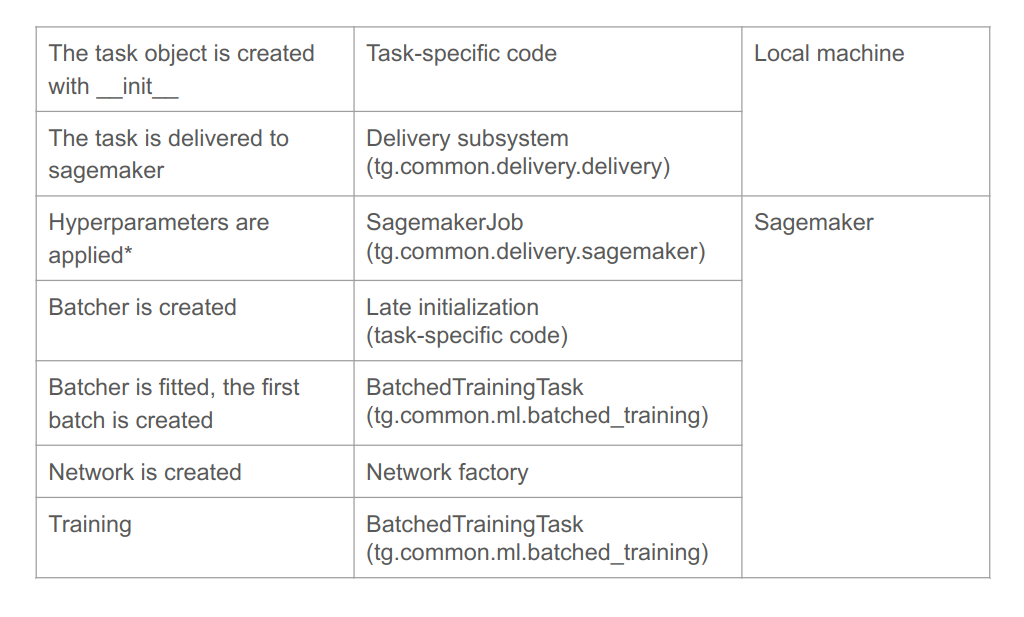

In [34]:
from IPython.display import Image

Image('files/stages.png')

In [42]:
import torch

class Network(torch.nn.Module):
    def __init__(self, head, hidden_size):
        super(Network, self).__init__()
        self.head = head
        self.tail = btf.Perceptron(hidden_size, 1)
        
    def forward(self, batch):
        return self.tail(self.head(batch))
    
class NetworkFactory:
    def __init__(self, assembly_point):
        self.assembly_point = assembly_point
        
    def __call__(self, batch):
        head_factory = self.assembly_point.create_network_factory()
        head = head_factory(batch)
        return Network(head, self.assembly_point.hidden_size)
    
network_factory = NetworkFactory(ap)
network = network_factory(batch)
network(batch)

tensor([[0.5716],
        [0.5692],
        [0.5626]], grad_fn=<SigmoidBackward0>)

### Advanced approach

The simple approach _is fine_. However, if you test a lot of networks, it might result in excessive code: lots of factories sharing lots of code. For instance, this idea that in a feed-forward network the following layer has the same amount of nods as the previous layer has outputs.

There is some architecture to address this. To this moment I'm still unsure if it worthes it: looks good, but doesn't provide so much benefits. So, again: simple approach is fine.

In [47]:
class Network(torch.nn.Module):
    def __init__(self, head, hidden_size):
        super(Network, self).__init__()
        self.head = head
        self.tail = btf.Perceptron(hidden_size, 1)
        
    def forward(self, batch):
        return self.tail(self.head(batch))
    
    class Factory:
        def __init__(self, assembly_point):
            self.head_factory = head_factory
            
        def __call__(self, batch):
            head = self.head_factory(batch)
            intermediate_tensor = head(batch)
            return Network(head, intermediate_tensor)
            
            
        
    
network_factory = Network.Factory(ap.create_network_factory())
network = network_factory(batch)
network(batch)

tensor([[0.4393],
        [0.4529],
        [0.4458]], grad_fn=<SigmoidBackward0>)

In [48]:
from functools import partial

factory = btf.FeedForwardNetwork.Factory(
    ap.create_network_factory(),
    partial(btf.Perceptron, output_size = 1)
)
network = factory(batch)
network(batch)

tensor([[0.4593],
        [0.4669],
        [0.4390]], grad_fn=<SigmoidBackward0>)

## Training task

TG supports "delivery as objects": instead of running notebooks cell after cell, going through the stages of training, we:

* define the object that fully describes the training
* package this code _and all the current code base_ in a docker container
* run this container on the remote server.

This requires some code infrastructure (tg.common.delivery) and puts some constraints to how the code should be organized. Now, why are we doing this?

* Writing lots of code in a notebook **is not** a good practice.
  * How do you reuse it? How do you test it? How do you version it? How do you use it in the software?
  * Yes, there are now various solutions kinda allowing doing this - but they all look like an attempt to fix what's broken from the start. Also they typically cost money.
  * Instead of inventing the bicycle, it's much easier to stick to the old-school coding practices (write in IDE, test with Pytorch, reuse with SOLID) and solve this only question of delivery. 
  * Experimenting in the notebook is fine though. But the code from these experiments should then be put in modules and tested as due.
* Locking oneself on the platform **is not** a good practice.
  * If you only know how to use Sagemaker, what are you going to do if it raises prices a lot?
  * Docker container is a simple entity that can typically run in every cloud (if the cloud can't run it - it's a bad cloud). We were able to run stuff on Yandex Datashpere amazingly quick, and we didn't adjust any task-specific code, just wrote a slim infrastructure layer.
  
  

  

2023-02-10 13:14:54.098842 INFO: Training starts. Info: {}
2023-02-10 13:14:54.101172 INFO: Ensuring/loading bundle. Bundle before:
{'index': {'shape': (2144, 4), 'index_name': 'sample_id'}, 'slovnet': {'shape': (49990, 17), 'index_name': 'word_id'}, 'syntax_closure': {'shape': (128382, 4), 'index_name': 'entry_id'}, 'syntax_fixes': {'shape': (49990, 4), 'index_name': 'word_id'}, 'syntax_stats': {'shape': (49990, 6), 'index_name': 'word_id'}, 'pymorphy': {'shape': (49990, 16), 'index_name': 'word_id'}, 'src': {'shape': (49990, 17), 'index_name': None}}
2023-02-10 13:14:54.103556 INFO: Bundle loaded
{'index': {'shape': (2144, 4), 'index_name': 'sample_id', 'columns': ['word_id', 'sentence_id', 'label', 'split'], 'index': [3, 21, 39, 45, 76, '...']}, 'slovnet': {'shape': (49990, 17), 'index_name': 'word_id', 'columns': ['POS', 'Animacy', 'Case', 'Gender', 'Number', '...'], 'index': [0, 1, 2, 3, 4, '...']}, 'syntax_closure': {'shape': (128382, 4), 'index_name': 'entry_id', 'columns': ['wo

2023-02-10 13:15:03.524397 INFO: ###loss:0.21969030192121863
2023-02-10 13:15:03.524950 INFO: ###iteration:7
2023-02-10 13:15:03.529573 INFO: Epoch 8 of 10
2023-02-10 13:15:03.950416 INFO: Training: 0/1 batch, 0/4 mini-epoch
2023-02-10 13:15:04.011971 INFO: Training: 0/1 batch, 1/4 mini-epoch
2023-02-10 13:15:04.073396 INFO: Training: 0/1 batch, 2/4 mini-epoch
2023-02-10 13:15:04.132352 INFO: Training: 0/1 batch, 3/4 mini-epoch
2023-02-10 13:15:04.192871 INFO: test: 0/1
2023-02-10 13:15:04.382944 INFO: display: 0/1
2023-02-10 13:15:04.589750 INFO: ###roc_auc_score_test:0.76845265098501
2023-02-10 13:15:04.590431 INFO: ###roc_auc_score_display:0.7820617040219874
2023-02-10 13:15:04.590951 INFO: ###loss:0.21379472175613046
2023-02-10 13:15:04.591405 INFO: ###iteration:8
2023-02-10 13:15:04.592052 INFO: Epoch 9 of 10
2023-02-10 13:15:05.010849 INFO: Training: 0/1 batch, 0/4 mini-epoch
2023-02-10 13:15:05.061368 INFO: Training: 0/1 batch, 1/4 mini-epoch
2023-02-10 13:15:05.118751 INFO: Tra

<AxesSubplot: >

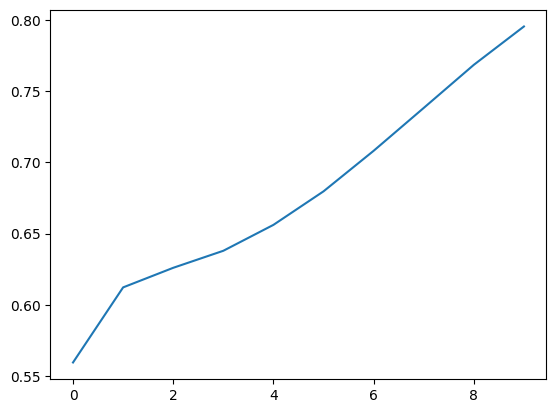

In [49]:
from sklearn.metrics import roc_auc_score
import pandas as pd

class TrainingTask(btf.TorchTrainingTask):
    def __init__(self):
        super(TrainingTask, self).__init__()
        self.metric_pool = bt.MetricPool().add_sklearn(roc_auc_score)
        self.features_ap = create_assembly_point()
    
    def initialize_task(self, idb):
        self.setup_batcher(idb, [ap.create_extractor(), create_label_extractor()])
        self.setup_model(factory, ignore_consistancy_check=True)
        
task = TrainingTask()
task.settings.epoch_count=10
result = task.run(db)
pd.DataFrame(result['output']['history']).roc_auc_score_test.plot()